# Very simple startup with Spark (WORKING!!!)

In [4]:
import ujson
import ast

def json_parser(line):
    review_dictionary = ast.literal_eval(line)
    if 'price' in review_dictionary.keys():
        
        #yield "reviewerID", review_dictionary['reviewerID']
        #yield "asin", review_dictionary['asin']
        #yield "reviewerName", review_dictionary['reviewerName']
        #yield "helpful", review_dictionary['helpful']
        #yield "reviewText", review_dictionary['reviewText']
        yield "price", review_dictionary['price']
        #yield "summary", review_dictionary['summary']
        #yield "unixReviewTime", review_dictionary['unixReviewTime']
        #yield "reviewTime", review_dictionary['reviewTime']
        yield 'count', 1
    
lines = sc.textFile("../../amazon_dataset/metadata.json")
review_values = lines.flatMap(json_parser)
key_lists = review_values.reduceByKey(lambda a,b: a+b)

a = key_lists.collect()

print a

print a[0][1]*1.0/a[1][1]

[('count', 6063208), ('price', 211831713.8699847)]
0.0286227585531


In [57]:
result = {}
for elm in a:
    if elm[0]=='count':
        result['count']=elm[1]
    else:
        result['price']=elm[1]

In [58]:
print 'The average price of all the products is:',result['price']/result['count']

The average price of all the products is: 34.9372335354


In [1]:
music = spark.read.json('../../amazon_dataset/reviews_Musical_Instruments_5.json')
music.printSchema()

root
 |-- asin: string (nullable = true)
 |-- helpful: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: long (nullable = true)



In [76]:
music.registerTempTable('music')
result = spark.sql("SELECT asin as ProductID,summary,helpful,unixReviewTime FROM music WHERE overall==5.0 AND helpful[1]-helpful[0]<10 AND helpful[0]!=0 AND helpful[1]!=0 AND helpful[0]>100")
result.show(10, truncate=False)

+----------+------------------------------------------------------------+----------+--------------+
|ProductID |summary                                                     |helpful   |unixReviewTime|
+----------+------------------------------------------------------------+----------+--------------+
|B0002GXZK4|This guitar DOES have a BIG SOUND for a small price         |[156, 160]|1111708800    |
|B0002H0H4A|The Pop Rocks with the Yeti                                 |[101, 105]|1342656000    |
|B000B6DHB2|Impressive Sound from an Inexpensive Source - UPDATE 7/11/14|[130, 136]|1230422400    |
|B000BWEM42|Well built folding stand great for guitar music and tab     |[156, 161]|1197504000    |
|B002Q0WSO8|Finally!  Amazon offers the Intelli IMT-500                 |[188, 193]|1177027200    |
|B003FVB7XA|Considerably better than anticipated!                       |[259, 266]|1223683200    |
|B0042EZH6W|Bought it for my Kid. Now I'm buying it for myself!         |[190, 192]|1293753600    |


In [43]:
filtered = music.filter(music.overall>3.5).show(10)

+----------+-------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|      asin|helpful|overall|          reviewText| reviewTime|    reviewerID|        reviewerName|             summary|unixReviewTime|
+----------+-------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|0528881469| [0, 0]|    5.0|We got this GPS f...| 06 2, 2013| AO94DHGC771SJ|             amazdnu|     Gotta have GPS!|    1370131200|
|0594451647| [3, 3]|    5.0|I am using this w...| 01 3, 2014|A2JXAZZI9PHK9Z|Billy G. Noland "...|HDMI Nook adapter...|    1388707200|
|0594451647| [0, 0]|    5.0|This adaptor is r...| 05 4, 2014| AAZ084UMH8VZ2|D. L. Brown "A Kn...|A Perfdect Nook H...|    1399161600|
|0594451647| [0, 0]|    4.0|This adapter easi...|07 11, 2014| AEZ3CR6BKIROJ|        Mark Dietter|A nice easy to us...|    1405036800|
|0594451647| [3, 3]|    5.0|This product real...|01 20, 2014|A

In [46]:
music.drop('reviewerName')

DataFrame[asin: string, helpful: array<bigint>, overall: double, reviewText: string, reviewTime: string, reviewerID: string, summary: string, unixReviewTime: bigint]

In [74]:
music.unixReviewTime.alias('Unix Review Time')

Column<unixReviewTime AS `Unix Review Time`>

In [87]:
music.select('asin').groupby('asin').count().sort('count',ascending=False).show()

+----------+-----+
|      asin|count|
+----------+-----+
|B003VWJ2K8|  163|
|B0002E1G5C|  143|
|B0002F7K7Y|  116|
|B003VWKPHC|  114|
|B0002H0A3S|   93|
|B0002CZVXM|   74|
|B0006NDF8A|   71|
|B0009G1E0K|   69|
|B0002E2KPC|   68|
|B0002GLDQM|   67|
|B004XNK7AI|   65|
|B005FKF1PY|   63|
|B00646MZHK|   62|
|B0002GMGYA|   58|
|B001PGXHX0|   58|
|B0018TIADQ|   57|
|B000978D58|   57|
|B001PGXKC8|   55|
|B0002D0CEO|   55|
|B000068NW5|   52|
+----------+-----+
only showing top 20 rows



# IMPORTANT: Parsing and Querying

## Parsing Reviews and Metadata

In [80]:
import ujson
from toolz import dissoc
import datetime
import re
import time
from pyspark.sql.types import *
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
stopwords = stopwords.words('english')
from string import punctuation
import re
from matplotlib import pyplot as plt
import random
%matplotlib inline
import pprint
import pickle
from prettytable import PrettyTable
import numpy as np
import operator

Using this function to properly parse each JSON dict:

In [2]:
#Function used to convert a UNIX timestamp to a proper datetime object (more human-readable):
def convert_date(date):
    date = datetime.date.fromtimestamp(int(date))
    return date

#Used to remove reviewerName (not interesting) and to convert UNIX timestamp in date object
def reviews_parser(line):
    try:
        line = ujson.loads(line)
        line['productID'] = line['asin']
        line['reviewTime'] = convert_date(line['unixReviewTime'])        
    except:
        line['reviewTime'] = None
    return dissoc(line,'reviewerName','unixReviewTime','asin')

#Metadata parser, we use this to clean the dictionary and make it more usable for a DataFrame
#There are some records that lack some keys, that's why we need to set them as None where missing
def metadata_parser(line):
    d = eval(line)
    d['productID'] = d['asin']
    if not d.has_key('categories'):
        d['categories']=None
    else:
        d['categories'] = list(set([category for set_of_categories in d['categories']
                                    for category in set_of_categories]))
    if not d.has_key('salesRank'):
        d['salesRankCategories']=None
        d['salesRankValues'] = None
    else:
        d['salesRankCategories'] = d['salesRank'].keys()
        d['salesRankValues'] = d['salesRank'].values()
    if not d.has_key('related'):
        d['related']=None
    if not d.has_key('description'):
        d['description']=None
    if not d.has_key('brand'):
        d['brand']=None
    if not d.has_key('price'):
        d['price']=None
    return dissoc(d,'asin','salesRank')

We're using the `k_core_no_books.json` so we get rid of books, which are not relevant for our analysis. Amazon became something like a huge book shop and more than 50% of the total reviews are for books, so they're actually involving other parameters regarding the content of the book. We are focusing on reviews for each specific product.

In [69]:
ec2_path = '/home/ec2-user/amazon_dataset/'
ricky_path = 'C:\\dtu\\ctbd\\amazon_dataset\\'
ricky_pickled_objects_folder = 'pickled_objects\\'

#EDIT THIS PATH ACCORDING TO THE CURRENT WORKING MACHINE!!!
path = ricky_path
pickled_objects_folder = ricky_pickled_objects_folder

f_reviews = path+'kcore_5_no_books.json'
f_metadata = path+'metadata_no_books.json'

#Definition of schema for the reviews DataFrame
string_fields = ['productID','reviewText','reviewerID','summary']
fields = [StructField(field_name, StringType(), False) for field_name in string_fields]
fields+=[StructField('reviewTime',DateType(),True),
         StructField('overall',FloatType(),False),
         StructField('helpful',ArrayType(IntegerType(),containsNull=False),False)]
reviews_schema = StructType(fields)

reviews = sc.textFile(f_reviews)
reviews = reviews.map(reviews_parser)
reviews = reviews.toDF(reviews_schema)

#Definition of schema for the metadata DataFrame
fields = [StructField('productID',StringType(),False),
          StructField('brand',StringType(),True),
          StructField('categories',ArrayType(StringType(),True),True),
          StructField('description',StringType(),True),
          StructField('imUrl',StringType(),True),
          StructField('price',FloatType(),True),
          StructField('title',StringType(),True),
          StructField('related',StructType([StructField('also_bought',ArrayType(StringType(),True),True),
                                  StructField('also_viewed',ArrayType(StringType(),True),True),
                                  StructField('bought_together',ArrayType(StringType(),True),True),
                                  StructField('buy_after_viewing',ArrayType(StringType(),True),True)]),True),
          StructField('salesRankCategories',ArrayType(StringType(),True),True),
          StructField('salesRankValues',ArrayType(IntegerType(),True),True)]

metadata_schema = StructType(fields)
metadata = sc.textFile(f_metadata)
metadata = metadata.map(metadata_parser)
metadata = metadata.toDF(metadata_schema)

In [143]:
reviews.printSchema()

root
 |-- productID: string (nullable = false)
 |-- reviewText: string (nullable = false)
 |-- reviewerID: string (nullable = false)
 |-- summary: string (nullable = false)
 |-- reviewTime: date (nullable = true)
 |-- overall: float (nullable = false)
 |-- helpful: array (nullable = false)
 |    |-- element: integer (containsNull = false)



In [5]:
metadata.printSchema()

root
 |-- productID: string (nullable = false)
 |-- brand: string (nullable = true)
 |-- categories: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- description: string (nullable = true)
 |-- imUrl: string (nullable = true)
 |-- price: float (nullable = true)
 |-- title: string (nullable = true)
 |-- related: struct (nullable = true)
 |    |-- also_bought: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- also_viewed: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- bought_together: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- buy_after_viewing: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |-- salesRankCategories: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- salesRankValues: array (nullable = true)
 |    |-- element: integer (containsNull = true)



In [80]:
reviews.show(10)

+----------+--------------------+--------------+--------------------+----------+-------+--------+
| productID|          reviewText|    reviewerID|             summary|reviewTime|overall| helpful|
+----------+--------------------+--------------+--------------------+----------+-------+--------+
|1384719342|Not much to write...|A2IBPI20UZIR0U|                good|2014-02-28|    5.0|  [0, 0]|
|1384719342|The product does ...|A14VAT5EAX3D9S|                Jake|2013-03-16|    5.0|[13, 14]|
|1384719342|The primary job o...|A195EZSQDW3E21|It Does The Job Well|2013-08-28|    5.0|  [1, 1]|
|1384719342|Nice windscreen p...|A2C00NNG1ZQQG2|GOOD WINDSCREEN F...|2014-02-14|    5.0|  [0, 0]|
|1384719342|This pop filter i...| A94QU4C90B1AX|No more pops when...|2014-02-21|    5.0|  [0, 0]|
|B00004Y2UT|So good that I bo...|A2A039TZMZHH9Y|      The Best Cable|2012-12-21|    5.0|  [0, 0]|
|B00004Y2UT|I have used monst...|A1UPZM995ZAH90|Monster Standard ...|2014-01-19|    5.0|  [0, 0]|
|B00004Y2UT|I now us

In [145]:
metadata.select('productID','price','title','categories').show(10)

+----------+-----+--------------------+--------------------+
| productID|price|               title|          categories|
+----------+-----+--------------------+--------------------+
|0000143561|12.99|Everyday Italian ...|[Movies, Movies &...|
|0000037214| 6.99|Purple Sequin Tin...|[Novelty, Costume...|
|0000032069| 7.89|Adult Ballet Tutu...|[Other Sports, Da...|
|0000031909|  7.0|Girls Ballet Tutu...|[Dance, Other Spo...|
|0000032034| 7.87|Adult Ballet Tutu...|[Other Sports, Da...|
|0000589012|15.95|Why Don't They Ju...|[Movies, Movies &...|
|0000031852| 3.17|Girls Ballet Tutu...|[Dance, Other Spo...|
|0000032050|12.85|Adult Ballet Tutu...|[Other Sports, Da...|
|0000695009| null|Understanding Sei...|[Movies, Movies &...|
|000107461X| null|Live in Houston [...|[Movies, Movies &...|
+----------+-----+--------------------+--------------------+
only showing top 10 rows



This command is needed in order to register the table names like `reviews` and `metadata` which can be used directly in SQL queries.

In [32]:
reviews.registerTempTable('reviews')
metadata.registerTempTable('metadata')

Let's count the total number of reviews:

In [13]:
spark.sql('SELECT count(*) AS Total_Reviews FROM reviews').show()

+-------------+
|Total_Reviews|
+-------------+
|      9288692|
+-------------+



Instead, let's count the total number of product metadata:

In [147]:
spark.sql('SELECT count(*) AS Number_Of_Products FROM metadata').show()

+------------------+
|Number_Of_Products|
+------------------+
|           6984215|
+------------------+



So, our dataset contains **9M+ reviews** and **6M+ products**.

## Example queries:

### Reviews

**Date**: there are some problems, in the schema it's listed as 'date' type, instead it's impossible to extract year/month/day from the object (it raises exception); it works if it's treated as string object... WTF?

In [11]:
reviews.filter(reviews.reviewTime.startswith('2013-12-25')).show(10)

+----------+--------------------+--------------+--------------------+----------+-------+-------+
| productID|          reviewText|    reviewerID|             summary|reviewTime|overall|helpful|
+----------+--------------------+--------------+--------------------+----------+-------+-------+
|B000068O1N|Haven't used it y...|A3UPEG3LRWOX16|         Nice Cables|2013-12-25|    4.0| [0, 0]|
|B0002E1G5C|Overall, I like t...|A19Q4B515ENF9C|Does the job but ...|2013-12-25|    4.0| [0, 0]|
|B0002E1I2I|I bought my new g...|A19Q4B515ENF9C|I guess this work...|2013-12-25|    3.0| [0, 0]|
|B0006NDF8A|This is fine for ...|A19Q4B515ENF9C|Works fine and pr...|2013-12-25|    5.0| [0, 0]|
|B002NG7DEK|This strap works ...|A19Q4B515ENF9C|Works great for m...|2013-12-25|    4.0| [0, 0]|
|B005LYIW3W|This pedal is ver...|A2W03JTG0K5OKF|         Great Tone!|2013-12-25|    5.0| [0, 0]|
|B0006IX7Y2|Easy to use, easy...|A2KS03QLEXP09W|       Great product|2013-12-25|    5.0| [0, 0]|
|B0007LVJ20|Easy to use. Keep.

Not working treating the reviewTime as a date object and trying to extract its attributes:

In [26]:
reviews.filter(reviews.reviewTime.year==2014).show(10)

AnalysisException: u"Can't extract value from reviewTime#78;"

Querying along **helpful**:

In [7]:
reviews.filter(reviews.helpful[1]-reviews.helpful[0]>20).show()

+----------+--------------------+--------------+--------------------+----------+-------+----------+
| productID|          reviewText|    reviewerID|             summary|reviewTime|overall|   helpful|
+----------+--------------------+--------------+--------------------+----------+-------+----------+
|B0002CZV82|This is a cheap p...|A2B58VXLLOFQKR|         It distorts|2009-11-13|    1.0|   [2, 30]|
|B000T9NKEU|It was Not what I...|A3MJARDJ31M698|       Cost Too Much|2010-06-05|    1.0|   [0, 30]|
|B000ULAP4U|garbage if you li...|A1B3CNORXB1USI|almost zero stars...|2012-06-12|    1.0| [11, 101]|
|B0042F1L4S|My review(s) for ...|A2OPSPL8LSSJPC|this amp is ooooo...|2012-01-24|    1.0|   [5, 30]|
|B004OU2IQG|allotoday went to...|A1B3CNORXB1USI|so so for  conver...|2012-10-25|    1.0|  [17, 65]|
|B004TE5HBU|Just use a smartp...|A16Z3HTUIYPDH8|    Use a smartphone|2013-03-13|    1.0|   [5, 38]|
|B0002U2V1Y|I have a 1998 Ram...| A4WCZVA328QB4|Claying is more f...|2009-09-24|    3.0|[137, 177]|


Querying along **productID**:

In [ ]:
reviews.groupBy('productID').count().sort('count',ascending=False).show()

Querying along **reviewerID**:

In [36]:
reviews.groupBy('reviewerID').count().withColumnRenamed("count", "total").sort('total',ascending=False).filter('total%2==0').show(10)

+--------------+-----+
|    reviewerID|total|
+--------------+-----+
| A9Q28YTLYREO7|  578|
| A8IFUOL8S9BZC|  256|
|A1GN8UJIZLCA59|  246|
|A200C7YQJ45LRR|  200|
|A1J5KCZC8CMW9I|  182|
| A8SCX6VUTE05H|  172|
|A2582KMXLK2P06|  160|
|A1IKOYZVFHO1XP|  144|
|A12R54MKO17TW0|  132|
|A2ETZ7GF5B1712|  130|
+--------------+-----+
only showing top 10 rows



Querying along **reviewText** (same as **summary**):

In [12]:
reviews.filter(reviews['reviewText'].startswith('Shit')).sort('overall',ascending=False).show()

+----------+--------------------+--------------+--------------------+----------+-------+-------+
| productID|          reviewText|    reviewerID|             summary|reviewTime|overall|helpful|
+----------+--------------------+--------------+--------------------+----------+-------+-------+
|B00GN8K6CU|Shit just got rea...|A1BQO66R6OLCCW|                 Wow|2013-11-19|    5.0| [1, 1]|
|B00HGOMTP2|Shit is off the c...|A1VT0G2BIAWMQJ|OMG SHELLI U DID DAT|2013-12-22|    5.0| [0, 0]|
|B00G9IYA5I|Shit just got rea...|A1BQO66R6OLCCW|               Omg!!|2013-10-31|    5.0| [3, 3]|
|B00FOQ6LW6|Shit just got rea...|A1BQO66R6OLCCW|                 Wow|2013-11-24|    5.0| [0, 0]|
|B00HFSMF76|Shit just got rea...|A1BQO66R6OLCCW|                 Wow|2014-01-16|    5.0| [0, 0]|
|B00F0UCDL4|Shit is about to ...|A1BQO66R6OLCCW|               Wow!!|2013-09-09|    5.0| [0, 0]|
|B0087ZUNR0|Shit just got rea...|A1BQO66R6OLCCW|                 Wow|2013-12-19|    5.0| [0, 0]|
|0756408148|Shit just got rea.

### Metadata

Querying along **price** (let's find the top 20 most expensive produts):

In [9]:
start = time.time()
metadata.select('productID','categories','price','title').sort(metadata.price.desc()).show()
end = time.time()
print 'Execution time:',datetime.timedelta(seconds=(end-start))

+----------+--------------------+------+--------------------+
| productID|          categories| price|               title|
+----------+--------------------+------+--------------------+
|B000FE5LMS|[Video Games, Gam...|999.99|                null|
|B000FIUIIQ|[Digital Pianos, ...|999.99|Yamaha P140S Digi...|
|B000FIUYPI|[Digital Pianos, ...|999.99|Yamaha P-140 Port...|
|B000BPWVR4|[Office Products,...|999.99|Brother MFC-9420C...|
|B000DBHTL4|[Toys & Games, Sp...|999.99|Naturally Playful...|
|B00004T9L1|[Tools & Home Imp...|999.99|JET 354170/JDP-20...|
|B0009PEX0O|[Video Games, Gam...|999.99|                null|
|B0002FGV6A|[Electronics, Vid...|999.99|InFocus LP600 Bus...|
|B00061HFME|      [Toys & Games]|999.99|58321 1/10 Super ...|
|B0009RF7FM|[Medical Supplies...|999.99|Shoprider Dasher ...|
|B0007SXAI4|[Toys & Games, RC...|999.99|WowWee Robosapien...|
|B00004SVV8|[Video Games, Gam...|999.99|                null|
|B00004SVVA|[Video Games, Gam...|999.99|                null|
|B00004S

Actually this shows that our dataset is limited to those products whose price is lower than 1000$.

# Start of the interesting analysis

1) Reviews' helpfulness (most helpful?)

2) Correlation between the reviews we identified in the previous step and the relative products

3) Most appreciated products (highest overall average)[per category?]

4) Overall score and sentiment: do this two parameters agree with each other? *(Is the text of the review expressing the same sentiment of the text?)*

5) Temporal analysis:

## 1) Reviews' Helpfulness
Which are the most helpful reviews ever? In order to say this we can take in consideration the `helpful` parameter: it is represented as an array of 2 elements, where the second one indicates how many people *voted* the review, and the first one tells how voters out of the total considered this review *helpful*. The difference between these two values, thus, tells how many considered this review not helpful.

Since there are lots of reviews with very few voters, we should filter them and take in consideration just reviews that were voted a lot of times. Let's calculate the **average number of voters** (we obviously exclude those reviews that were never voted):

In [9]:
spark.sql("SELECT avg(helpful[1]) FROM reviews WHERE helpful[0]>0 AND helpful[1]>0").show()

+-----------------+
|  avg(helpful[1])|
+-----------------+
|8.431077453916476|
+-----------------+



The result above means that there are much more reviews with a low number of voters, which is obviously acceptable. Instead, let's try to find the **top 20 reviews with the highest number of voters**:

In [15]:
spark.sql("SELECT * FROM reviews ORDER BY helpful[1] DESC").show()

+----------+--------------------+--------------+--------------------+----------+-------+--------------+
| productID|          reviewText|    reviewerID|             summary|reviewTime|overall|       helpful|
+----------+--------------------+--------------+--------------------+----------+-------+--------------+
|B0047E0EII|For decades I hav...|A1TTA1UUGY4WY4|No more winning f...|2011-03-03|    5.0|[52176, 52861]|
|B0074BW614|I've been an iPad...|A3QCF8CVINEXB8|You Get What You ...|2012-09-17|    4.0|[30735, 31453]|
|B007FTE2VW|Fundamentally, Si...|A1DQOJ8PLXVPCO|    What a lousy toy|2013-03-06|    1.0|[10279, 10533]|
|B0029OSN4U|The primary diffe...|A3FKPBNI7UWQFW|Salon Laser Hair ...|2010-04-05|    4.0|  [9634, 9717]|
|B000FKBCX4|See those older 5...|A3284KYDZ00BZA|Dumbed down exper...|2008-09-07|    1.0|  [8606, 9403]|
|B00B2V66VS|This game is the ...|A1SIOM22E22TYY|THIS GAME IS AWES...|2013-01-24|    5.0|  [8116, 9258]|
|B008PPGFZG|If you DO NOT hav...| AK7T18HR8HYU2|READ APP DESCRIP

We come up to an already interesting result: 

***Most of the top 20 most voted reviews were positive: their overall score is above 4.0; But there are two outliers, the 3rd and 5th reviews in the list: these reviews have an overall score of 1.0! ***

* It's evident that all these reviews are pretty much **recent**, most of them were written in the time range from 2010 to 2013, with a few reviews in 2007, 2008 and 2009.
* People tend to vote **much more good reviews rather than bad reviews**.
* However, there are few examples of **bad reviews** who got **A LOT of voters**, mostly supporting their opinion.
* Since Amazon is showing first the top reviews for each product, it comes quite natural that once a review becomes a "top review", its voters grow exponentially. That's why the number of voters of the first most voted reviews differ by such a high gap.
* Why did those top-voted reviews actually become *top*? We can take in consideration the review text and analyze it... 

Do the voters agree with the reviewer? Actually this last query just showed which are the *most voted reviews*, but didn't explicitly show *how many voters actually considered that review helpful*.
Thus, we're going to show now the **average of how many voters considered the review NOT helpful**, and then compare it to the **average of how many voters DO considered the review helpful**:

In [10]:
spark.sql("SELECT avg(helpful[1]-helpful[0]) AS Avg_Not_Helpful_Voters FROM reviews WHERE helpful[0]>0 AND helpful[1]>0").show()

+----------------------+
|Avg_Not_Helpful_Voters|
+----------------------+
|     1.833070324557537|
+----------------------+



In [11]:
spark.sql("SELECT avg(helpful[0]) AS Avg_Helpful_Voters FROM reviews WHERE helpful[0]>0 AND helpful[1]>0").show()

+------------------+
|Avg_Helpful_Voters|
+------------------+
|6.5980071293589395|
+------------------+



It's clear that **most of the voters do agree with the review**.

Let's look instead at those reviews with the **highest number of voters who STRONGLY didn't agree with the reviewer** (*so didn't consider the review helpful*):

In [12]:
spark.sql("SELECT * FROM reviews ORDER BY helpful[1]-helpful[0] DESC").show()

+----------+--------------------+--------------+--------------------+----------+-------+------------+
| productID|          reviewText|    reviewerID|             summary|reviewTime|overall|     helpful|
+----------+--------------------+--------------+--------------------+----------+-------+------------+
|B00AKIPBNS|They didnt make e...|A169RTOHC2SJPI|OUT OF STOCK!!!?????|2013-02-04|    1.0|  [20, 1853]|
|B00H5RYIBI|Often times, I lo...|A3CPJYAQMCUGNR|Purchased as a gi...|2014-01-02|    1.0|  [21, 1589]|
|B00IWULQQ2|Best look to the ...|A17XJCP9P9VSL0|Fictional fluff w...|2014-05-22|    1.0|  [24, 1250]|
|B00B2V66VS|This game is the ...|A1SIOM22E22TYY|THIS GAME IS AWES...|2013-01-24|    5.0|[8116, 9258]|
|B001KVZ6HK|Storytelling as a...|A3DGVB3T5QJNRE|About as Exciting...|2012-05-11|    1.0|  [33, 1170]|
|B005J6U77Q|I need to augment...|A3GGD7ZWVWIKOU|Flaccid Logos Spe...|2011-09-08|    1.0|  [24, 1057]|
|B0001VL0K2|Come on now New L...|A22VNXHU6IZ5MT|Come on New Line,...|2009-04-16|  

Actually we can do an interesting consideration: the output above clearly shows a **majority of negative reviews** (overall 1.0) than positive reviews (overall 5.0):
* this leads to state that **there are lots of negative reviews that a lot of people disagree with**, and...
* **there are some positive reviews with a relative high number of people who disagree with it**

If we carefully look at those **positive reviews**, it immediately points out that **the number of people who disagree is often much smaller than the number of people who agree**, and mostly we're talking about thousands of voters. Thus, we can simply state that this difference is acceptable and they can still be considered top reviews.

By the other hand, the **negative reviews** are quite different than the previous ones: we can divide them in two subsets:
* negative reviews with high number of voters and very small number of people who considered them helpful: possible candidates for no-sense reviews, they don't characterize very well the related product;
* negative reviews with high number of voters and people who considered them helpful: as well as we stated for the positive reviews, these can be considered top reviews, so they strongly characterize the product, even if in a bad way.

Therefore, in order to see **which top-reviews** (in terms of *number of voters*) **also gained the highest number of opinion supporters** (*people who agree with the review and the vote and think that the review is helpful*), we have to check where the **difference between** `helpful[1]` and `helpful[0]` **is minimum**. But, differently than the last query, we cannot simply revert the `ORDER BY` clause, because we might find many reviews with a very small number of voters.

We can assume it's reasonable to *filter* the reviews and take in consideration only those ones with *more than 3000 voters* (probably this will cut off some valid results...):

In [16]:
reviews.filter(reviews.helpful[1]>3000).sort(reviews.helpful[1]-reviews.helpful[0]).show()

+----------+--------------------+--------------+--------------------+----------+-------+------------+
| productID|          reviewText|    reviewerID|             summary|reviewTime|overall|     helpful|
+----------+--------------------+--------------+--------------------+----------+-------+------------+
|B0015EWMX8|I actually could ...|A27C6W7DLDD7QK|    Garmin Nuvi 255w|2008-06-30|    5.0|[3052, 3067]|
|B0002IQJ8W|This was my fourt...|A3RMAWK4ELOLRZ|          Mean Girls|2006-01-10|    5.0|[3013, 3038]|
|B002HWJT1A|Bose QC15 vs. Sen...|A2QDYGI5OETYV3|Bose QC15 vs. Sen...|2009-12-11|    5.0|[3198, 3225]|
|B0000U1OCI|Since getting att...|  A6FIAB28IS79|Best of Breed: Th...|2004-09-04|    5.0|[3443, 3475]|
|B004GFN2ZA|I thought it migh...|A1ITCVZ46MUB3A|Review from a Bio...|2011-11-27|    4.0|[3410, 3442]|
|B0023B14TK|If I'm going to s...|A17V9XL4CWTQ6G|The camcorder SHO...|2009-11-07|    5.0|[3553, 3585]|
|B000UUBCNO|My wife and I dec...| AC1YLEFC9AN5X|Great but not per...|2007-09-16|  

We can clearly state all of these are **top-reviews** (in terms of helpfulness), however we must be conscious that this is just a very small subset, and all of them are too many to be listed.

Now we can **analyze the text** of the reviews that appeared in the previous results and provide some specific examples for each of the subsets that we identified. We hereby define two functions that will be used to generate some interesting wordclouds:

In [47]:
def generate_string(texts):
    s = ''
    for summary,review in texts:
        clean_summary = re.sub(r'\d+','',summary)
        clean_review = re.sub(r'\d+','',review)
        tokens = [word.strip(punctuation).lower() for word in clean_summary.split() if word not in stopwords]
        tokens+=[word.strip(punctuation).lower() for word in clean_review.split() if word not in stopwords]
        s+=' '.join(tokens)
        s+=' '
    return s

def blue_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(240, 100%%, %d%%)" % random.randint(30, 50)

def generate_wordcloud(texts):
    wordcloud = WordCloud(mode='RGBA',
                          width=1400,
                          height=1000,
                          background_color=None,
                          margin=10,
                          color_func=blue_color_func).generate(generate_string(texts))
    plt.figure(figsize=(18,14))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

### Most voted reviews:

In [7]:
start = time.time()
result = spark.sql("SELECT * FROM reviews ORDER BY helpful[1] DESC").take(1000)
end = time.time()
print 'Total time:',datetime.timedelta(seconds=end-start)

Total time: 332 days, 21:36:00.008240


It's worth showing just the text of the review of the most voted review ever:

In [36]:
texts = [(row.asDict()['summary'],row.asDict()['reviewText']) for row in result]
print 'Summary:',texts[0][0]
print 'Review:',texts[0][1]

Summary: No more winning for you, Mr. Banana!
Review: For decades I have been trying to come up with an ideal way to slice a banana.  "Use a knife!" they say.  Well...my parole officer won't allow me to be around knives.  "Shoot it with a gun!"  Background check...HELLO!  I had to resort to carefully attempt to slice those bananas with my bare hands.  99.9% of the time, I would get so frustrated that I just ended up squishing the fruit in my hands and throwing it against the wall in anger. Then, after a fit of banana-induced rage, my parole officer introduced me to this kitchen marvel and my life was changed.  No longer consumed by seething anger and animosity towards thick-skinned yellow fruit, I was able to concentrate on my love of theatre and am writing a musical play about two lovers from rival gangs that just try to make it in the world.  I think I'll call it South Side Story.Banana slicer...thanks to you, I see greatness on the horizon.


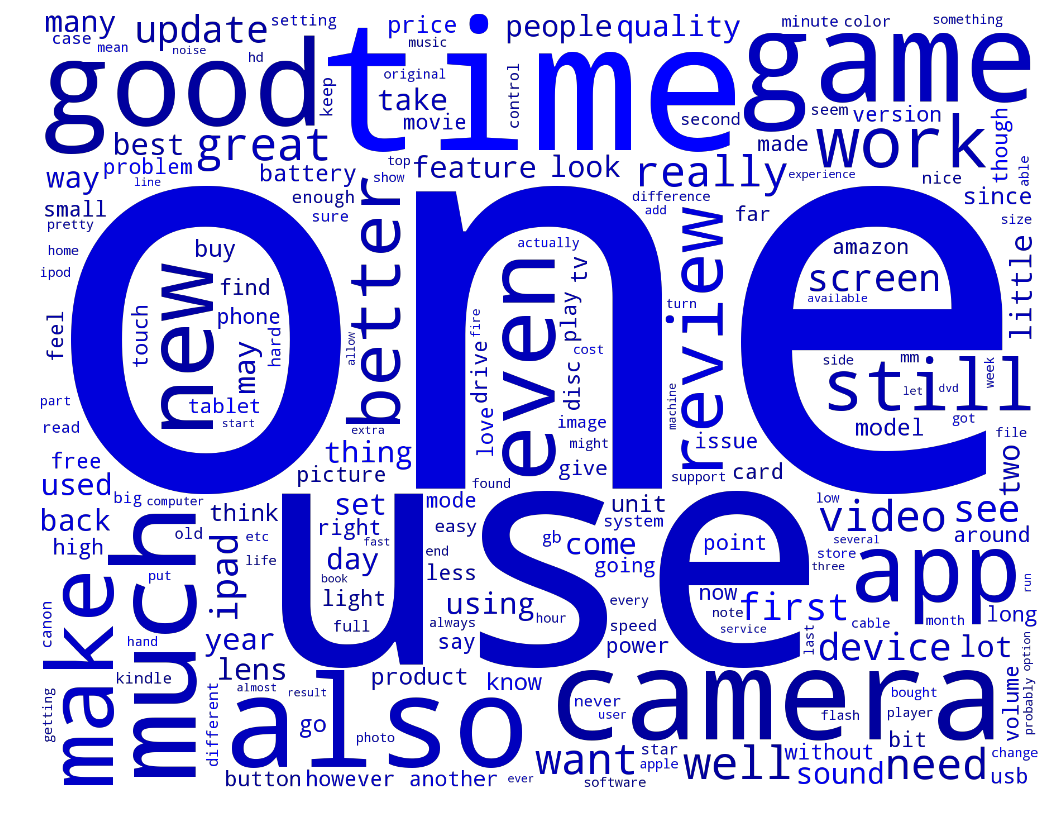

In [35]:
generate_wordcloud(texts)

### Worst reviews people didn't agree with

In [39]:
start = time.time()
result = spark.sql("SELECT * FROM reviews ORDER BY helpful[1]-helpful[0] DESC").take(1000)
end = time.time()
print 'Total time:',datetime.timedelta(seconds=end-start)

Total time: 0:05:58.045000


Again, let's see the text of the worst review ever:

In [40]:
texts = [(row.asDict()['summary'],row.asDict()['reviewText']) for row in result]
print 'Summary:',texts[0][0]
print 'Review:',texts[0][1]

Summary: OUT OF STOCK!!!?????
Review: They didnt make enough copy and not enough art books.This is unacceptable.Even though i love  JRPG, this game deserves 1 out of 5 since it messes with fan's mind.Plus i think call of duty vita is better than this game


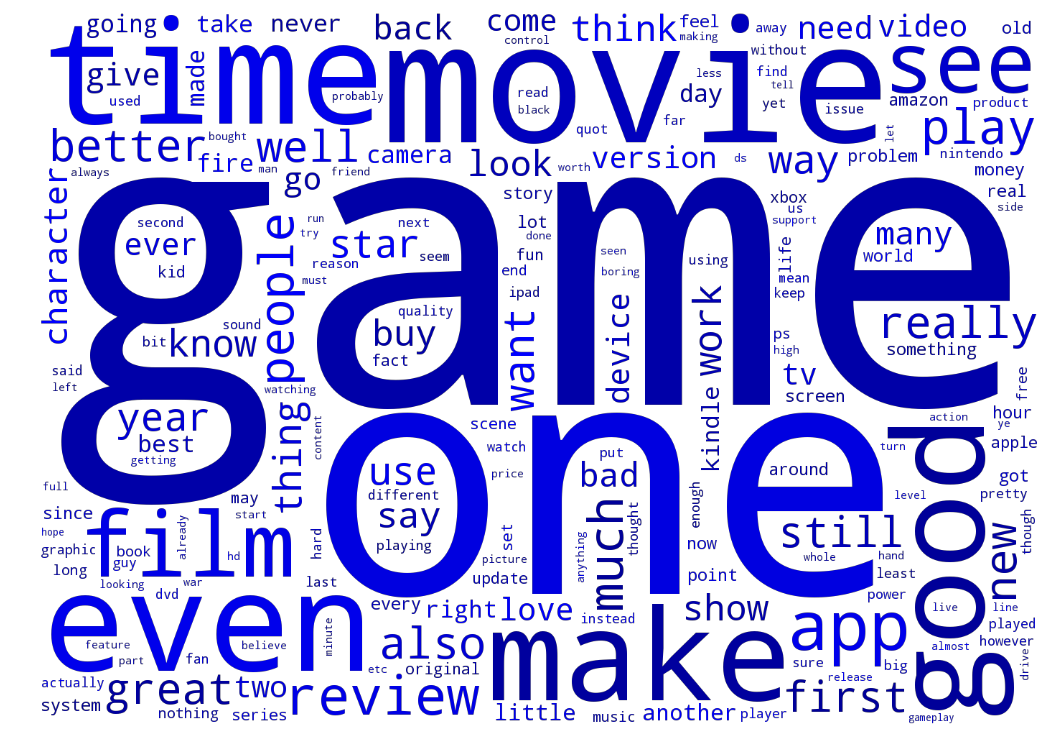

In [48]:
generate_wordcloud(texts)

We can notice some common frequent words between the two categories, despite the great difference between the two subsets.

## 2) Correlation between products and top reviews *(to be completed?)*
In the previous step we queried the reviews dataset but we're missing the information of the products related to the reviews we showed as output.

Let's start by showing the **top 20 products related to the most voted reviews**:

In [4]:
top_20 = reviews.select('productID','helpful').sort(reviews.helpful[1].desc()).take(20)

In [5]:
top_20_dict = [row.asDict() for row in top_20]

In [6]:
top_20_df = sc.parallelize(top_20_dict).toDF()

C:\spark\python\pyspark\sql\session.py:336: UserWarning: Using RDD of dict to inferSchema is deprecated. Use pyspark.sql.Row instead
  warnings.warn("Using RDD of dict to inferSchema is deprecated. "


In [7]:
cols = ['productID','title','price','brand','description','categories','salesRankCategories','salesRankValues']
products = metadata.select(cols).join(top_20_df,metadata.productID==top_20_df.productID,'inner').\
                                sort(top_20_df.helpful[1],ascending=False).collect()

In [17]:
df = sc.parallelize(products).toDF().drop('productID').drop('description')
df.show()

+--------------------+------------------+--------+--------------------+--------------------+---------------+--------------+
|               title|             price|   brand|          categories| salesRankCategories|salesRankValues|       helpful|
+--------------------+------------------+--------+--------------------+--------------------+---------------+--------------+
|Hutzler 571 Banan...|1.9700000286102295| Hutzler|[Home & Kitchen, ...|  [Kitchen & Dining]|         [1151]|[52176, 52861]|
|Kindle Fire HD 7&...|             199.0|    null|[eBook Readers & ...|                null|           null|[30735, 31453]|
|                null|29.989999771118164|    null|[PC, Video Games,...|       [Video Games]|         [1473]|[10279, 10533]|
|Tria&reg; Laser H...|              null|    null|[Shaving & Hair R...|[Health & Persona...|        [75398]|  [9634, 9717]|
|                null| 32.88999938964844|    null|[PC, Mac, Video G...|       [Video Games]|          [368]|  [8606, 9403]|
|       

In [30]:
df_rows = df.select('title','categories').collect()
df_dict = [row.asDict() for row in df_rows]
pprint.pprint(df_dict)

[{'categories': [u'Home & Kitchen',
                 u'Mandolines & Slicers',
                 u'Kitchen & Dining',
                 u'Kitchen Utensils & Gadgets',
                 u'Graters, Peelers & Slicers'],
  'title': u'Hutzler 571 Banana Slicer'},
 {'categories': [u'eBook Readers & Accessories',
                 u'Electronics',
                 u'eBook Readers'],
  'title': u'Kindle Fire HD 7&quot;, Dolby Audio, Dual-Band Wi-Fi, 16 GB'},
 {'categories': [u'PC', u'Video Games', u'Games'], 'title': None},
 {'categories': [u'Shaving & Hair Removal',
                 u'Health & Personal Care',
                 u'Electrolysis',
                 u'Hair Removal',
                 u'Personal Care'],
  'title': u'Tria&reg; Laser Hair Removal System - Gen 3 Previous Model (Discontinued)'},
 {'categories': [u'PC', u'Mac', u'Video Games', u'Games'], 'title': None},
 {'categories': [u'Games', u'Apps for Android'], 'title': None},
 {'categories': [u'Social Networking', u'Apps for Android'], '

## 3) Most appreciated products
We can calculate which products are the **most appreciated** ones according to the **average overall of their reviews** (*we must filter the results and for instance take only those products having at least 1000 reviews*):

In [38]:
most_appreciated = spark.sql("SELECT productID,avg(overall) as avg_overall FROM reviews GROUP BY productID HAVING count(*)>1000 ORDER BY avg_overall DESC LIMIT 100").collect()
top_100 = [row.asDict() for row in most_appreciated]
most_appreciated_df = sc.parallelize(top_100).toDF()

most_appreciated_ids = [row.asDict()['productID'] for row in most_appreciated]

In [65]:
#cols = ['productID','title','price','brand','description','categories','salesRankCategories','salesRankValues']
#products = metadata.select(cols).join(most_appreciated_df,metadata.productID==most_appreciated_df.productID,'inner').\
#                                sort(most_appreciated_df.avg_overall,ascending=False).collect()
    
df = sc.parallelize(products).toDF().drop('productID').drop('description').drop('salesRankCategories').drop('salesRankValues')
df.show()

+--------------------+------------------+----------------+--------------------+------------------+
|               title|             price|           brand|          categories|       avg_overall|
+--------------------+------------------+----------------+--------------------+------------------+
|                null|21.520000457763672|            null|[Movies, Movies &...| 4.890322580645162|
|Butler Creek Lula...|27.489999771118164|         MagLula|[Hunting & Fishin...| 4.879078694817658|
|AmazonBasics High...| 9.989999771118164|            null|[Cables & Interco...| 4.859760394644115|
|AmazonBasics USB ...| 5.789999961853027|            null|[Cables & Interco...| 4.829289428076256|
|Mediabridge ULTRA...| 8.989999771118164|     Mediabridge|[Cables & Interco...| 4.801164483260553|
|AmazonBasics High...|11.989999771118164|            null|[Cables & Interco...| 4.800386193579532|
|SanDisk 4GB Extre...|16.489999771118164|         SanDisk|[Electronics, Mem...|4.7936507936507935|
|Samsung E

Let's show the extended titles:

In [68]:
df = df.drop('price').drop('brand').drop('categories').drop('avg_overall')
df.filter(df.title!='null').show(truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------+
|title                                                                                                                                                 |
+------------------------------------------------------------------------------------------------------------------------------------------------------+
|Butler Creek Lula Universal Pistol Magazine Loader                                                                                                    |
|AmazonBasics High-Speed HDMI Cable 2-Pack - 6.5 Feet (2 Meters)                                                                                       |
|AmazonBasics USB 2.0 A-Male to A-Female Extension Cable - 9.8 Feet (3 Meters)                                                                         |
|Mediabridge ULTRA Series HDMI Cable (6 Feet) - High-Speed Supports Ethernet, 3D a

Saving DF on file with pickle:

In [71]:
with open(pickled_objects_folder+'most_appreciated_products','w') as f:
    pickle.dump(most_appreciated,f)

And how to unpickle:

In [72]:
with open(pickled_objects_folder+'most_appreciated_products','r') as f:
    most_appreciated_unpickled = pickle.load(f)

## 4) Overall score and sentiment *(to be completed)*
ML Classifier for understanding type of review? For example top review, or very bad review, etc... BOH?

## 5) Temporal Analysis
How did the reviews change over time? We can make some plots...
* How many reviews written every day? We can plot the distribution and see which days represent the peaks
* Same as before, but separated for negative reviews (overal <= 2.0) and positive reviews (overal >=3.0) and compare them
* Sentiment analysis over time: how much did the sentiment change in general?

### Distribution of the reviews over time

In [74]:
reviews_per_day = reviews.groupBy(reviews.reviewTime).count().select('reviewTime','count').collect()
with open(pickled_objects_folder+'reviews_per_day','w') as f:
    pickle.dump(reviews_per_day,f)

In [78]:
reviews_per_day = [row.asDict() for row in reviews_per_day]

In [87]:
reviews_per_day = sorted(reviews_per_day,key=lambda x: x['reviewTime'])

In [97]:
dates = [d['reviewTime'] for d in reviews_per_day]
frequencies = [d['count'] for d in reviews_per_day]

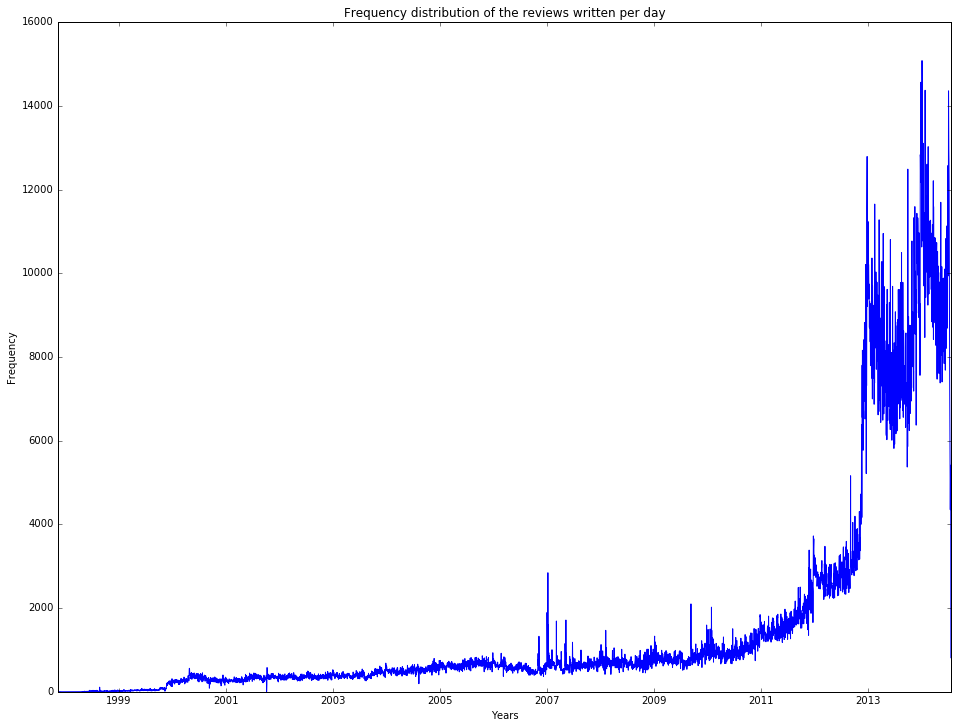

In [116]:
plt.figure(figsize=(16,12))
plt.plot(dates,frequencies)
plt.title('Frequency distribution of the reviews written per day')
plt.xlabel('Years')
plt.ylabel('Frequency')
plt.show()

(*Can we find the peaks? The outliers?*)

In [109]:
day_most_reviews = max(reviews_per_day,key=lambda x: x['count'])
print 'The day with the highest number of reviews was:',day_most_reviews['reviewTime'],'with:',day_most_reviews['count'],'reviews'

The day with the highest number of reviews was: 2014-01-07 with: 15082 reviews


In [108]:
print 'Average reviews per day:',np.mean(frequencies)
print 'Standard deviation:',np.std(frequencies)

Average reviews per day: 1556.9379819
Standard deviation: 2608.82600895


### Distribution of negative/positive reviews and comparison *(to be completed)*

In [ ]:
positive_reviews_per_day = reviews.filter(reviews.overall>=3.0).groupBy(reviews.reviewTime).\
                            count().select('reviewTime','count').collect()
with open(pickled_objects_folder+'positive_reviews_per_day','w') as f:
    pickle.dump(positive_reviews_per_day,f)
    
negative_reviews_per_day = reviews.filter(reviews.overall>=3.0).groupBy(reviews.reviewTime).\
                            count().select('reviewTime','count').collect()
with open(pickled_objects_folder+'negative_reviews_per_day','w') as f:
    pickle.dump(negative_reviews_per_day,f)